# Lab05 - 1D Atmosphere - Worksheet

Load relevant packages with the code below and check to make sure you are working in the right directory.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
%pip install ipympl
%pip install h5pyd cftime netcdf4 fsspec h5netcdf ffmpeg h5py xarray metpy
# %pip install matplotlib --upgrade

In [ ]:
# Imports used throughout the lab (arrays, plotting, data frames, ODE integration)
from pathlib import Path

import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

try:
  plt.style.use('bmh')
except:
  print('normal plotting style')

import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from datetime import datetime

import cftime
import fsspec
from netCDF4 import Dataset
import xarray as xr
import h5py

notebook_loc = Path(os.getcwd())
# check that has the right parent
if notebook_loc.parent.name != 'work':
  print('Please make a copy of this notebook and put it in your "work" folder!')
else:
  fig_dir = notebook_loc/'figures'
  fig_dir.mkdir(parents=True, exist_ok=True)
  print('Great, your figures will be saved in:', fig_dir)


def fig_save(fig_name, filetype='png'):
  fig_path = fig_dir/f'{fig_name}.{filetype}'
  unique_fig_path = fig_dir/f'{fig_path.name}__{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}{fig_path.suffix}'
  plt.savefig(fig_path, dpi=300)
  plt.savefig(unique_fig_path, dpi=300)


%matplotlib inline

### The $n$-layer model

In Lab 4, we treated the climate system as a single well-mixed box (0D). The surface temperature was determined directly by top-of-atmosphere energy balance. There was no internal structure: the surface was effectively connected straight to space.

Here we relax that assumption. We introduce vertical structure by stacking *n* atmospheric layers above the surface. Increasing *n* represents increasing optical thickness. More layers mean more absorption and re-emission events before radiation escapes to space. In this simple framework, *n* is a stand-in for greenhouse gas strength.

Define constants and the `nlayer` function, then compute surface temperature for different layer counts and exponents.

\1. Set the solar constant and surface albedo for an Earth-like case.

In [ ]:
S = 1370 # Solar constant
albedo = 0.3 # albedo

\2. Define a helper function that calculates surface temperature for a given number of layers.

In [ ]:
# The nlayer model, calculating surface temperature
def nlayer(n,S,albedo,expnt=4):
    '''input:
    n: number of layers
    S: solar constant
    albedo: fraction of reflection
    expnt: exponent in Stefan-Bolztmann's law

    Output:
    T: surface temperature'''
    from scipy import constants # for Stefan-Boltzman constant
    # solution of surface temperature
    T = ((n+1)*S*(1-albedo)/(4*constants.sigma))**(1./expnt)
    return T

\3. Compute surface temperature for a range of layer counts.

In [ ]:
# number of layers; equivalent to the amount of greenhouse gas in the atmosphere
layers = np.arange(100)
T_layer = nlayer(layers,S,albedo,4)

\4. Plot the relationship between layers and surface temperature.

As a step toward being able to tune your own plots specify a value of `xlabel` and `ylabel` in the `ax.set(` line below.

In [ ]:
# plot number of layers vs. surface temperature
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(layers,T_layer)
ax.set(xlabel= , ylabel= )

**Q (wb-q1):** How does the surface temperature change as the number of layers increases? Is this reasonable? At what point might it become unreasonable? Why?

**Q (wb-q2):** We know that blackbody emission scales as a power of temperature (in reality, $E=\sigma T^4$). What would happen in this model if the exponent were 2 instead of 4? What happens to the surface temperature?

Compare the surface temperature for exponent 2 versus 4. Then run the cell below to see how the surface temperature responds to changing the exponent, using an Earth-like case with $n=0.6$ (note that $n$ need not be an integer).

In [ ]:
exponent = 
print('surface temperature={:3.2f} K'.format(nlayer(2,S,albedo,exponent)))

In [ ]:
# what if the power number is not 4?
expnt = np.arange(2,7,0.2)
T_power = nlayer(0.6,S,albedo,expnt) # choose

plt.semilogy(expnt,T_power)

In the code below, plot surface temperature versus the exponent. For what range of exponents do we get a “livable” temperature? Add horizontal lines to the plot (with labels and line styling) to indicate a reasonable temperature range.

In [ ]:
plt.semilogy(expnt,T_power)
min_value = 
max_value = 

plt.axhline(min_value,color='gray',linestyle=':',label= )
plt.axhline(max_value,color='gray',linestyle='--',label= )
plt.legend()
plt.xlabel('Stefan-Boltzmann Exponent')
plt.ylabel('Surface temperature (K)')

**Q (wb-q3):** For what range of exponents do we get a “livable” temperature? Add horizontal lines to the plot (with labels and line styling) to indicate a reasonable temperature range. Also comment on why you chose this range.

------------------------------------------------------------------------

------------------------------------------------------------------------

## Part 2: A Radiative–Convective Model

### 2.1 What are we aiming for?

Before building the model, we need a target. What does the observed vertical temperature structure of Earth’s atmosphere actually look like? Here we use the NCEP/NCAR reanalysis data as the observations. The code below loads relevant packages and data for annual mean air temperature and computes its global average.

Load NCEP/NCAR reanalysis data, compute the global-mean profile, and build a skew‑T plot.

In [ ]:
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc

# Load data
ncep_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", decode_times=time_coder)

In [ ]:
# #  Compute a cosine‑latitude weighted global mean temperature profile.
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [ ]:
#  Define a helper function to plot a skew‑T diagram with reference adiabats.
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5,label='dry adiabats')
    skew.plot_moist_adiabats(linewidth=0.5,label='moist adiabats')
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set(xlabel = r'Temperature (${}^\circ$ C)', ylabel='Pressure (hPa)',  fontsize=14)
    # skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    # add height labels (secondary axis appears not to work): https://github.com/Unidata/MetPy/issues/262
    heights = np.array([2, 4, 6, 8, 10, 15, 20]) * units.km
    std_pressures = mpcalc.height_to_pressure_std(heights)
    for height_tick, p_tick in zip(heights, std_pressures):
        trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
        skew.ax.text(0.02, p_tick, '---{:~d}'.format(height_tick), transform=trans)

    return skew

In [ ]:
# Create the first skew‑T plot using the observed profile.
skew = make_skewT()

Before interpreting the profile, take a moment to understand the axes and background lines:

-   The vertical axis is **pressure** (in logarithmic scale). Pressure decreases upward and, through hydrostatic balance, serves as a proxy for height. Approximate height markers are shown to help you connect pressure to altitude.
-   The slanted colored lines represent dry and moist adiabats. You do not need to use them yet, but they will become important when we introduce convection.
-   The black curve shows the observed global-mean temperature profile.

> *Hydrostatic balance* is the balance between the downward force of the air above (and the weight of the parcel) and the upward pressure from the air below. To actually get from height to pressure, we would have to integrate over the height in question and make accomodation for density not being constant.

**Q (wb-q4):** What do we call the level at which temperature reaches a minimum? What do we call the layers immediately above and below it?

------------------------------------------------------------------------

------------------------------------------------------------------------

### 2.2 Radiative equilibrium

We begin by ignoring all processes except **radiation** and computing the temperature profile that results. This is called **radiative equilibrium**.

##### Water vapor data

Before setting up the model, we need the vertical distribution of water vapor. Why? Because water vapor is a radiatively active gas, and the strength of radiative absorption depends on how much is present at each level.

We will prescribe a fixed vertical profile of water vapor by computing the global annual-mean specific humidity at each level using output from a CESM (Community Earth System Model) control simulation, and use that as an input to the radiation model.

**WARNING:** downloading the data could take a minute.

Load CESM control data, compute a global-mean specific humidity profile, and visualize it.

1.  Open the CESM control dataset and access the specific humidity field.

In [ ]:
#  Load the model output as we have done before
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

\2. Compute the global annual mean specific humidity profile.

In [ ]:
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
# Take a look at what we just calculated ... it should be one-dimensional (vertical levels)
Qglobal

\3. Plot specific humidity versus pressure (convert to g/kg for readability).

In [ ]:
fig, ax = plt.subplots()

#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set(ylabel='Pressure (hPa)', xlabel='Specific humidity (g/kg)')
ax.grid()

**Q (wb-q5):** Think about what conditions lead to lower specific humidity versus higher. To get you going, think about winter and summer in Death Valley and central Pennsylvania. Describe two factors that contribute to the rapid decrease in specific humidity with increasing altitude in the troposphere.

##### Create a single-column model on the same grid

Now we create the vertical grid and define the model’s state variables: the surface temperature and the vertical profile of air temperature. We also specify an initial temperature profile and prescribe the humidity profile from above.

1.  Load climlab and initialize the column state on the CESM grid.

In [ ]:
import climlab

In [ ]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

\2. Configure the RRTMG radiation model with prescribed humidity and albedo.

In [ ]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )

radmodel

\3. Inspect which radiatively active gases are included.

In [ ]:
#  Volumetric mixing ratios
radmodel.absorber_vmr

\4. Run the model forward until top‑of‑atmosphere fluxes balance.

In [ ]:
radmodel.step_forward()
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()
 #  Check the top-of-atmosphere energy budget to make sure equilibrium has been reached
radmodel.ASR - radmodel.OLR

##### Compare the radiative equilibrium temperature to observations

**Q (wb-q6):** Write a few sentences addressing the following: What is a moist adiabat? What is a dry adiabat? Explain the paths of the dry and moist adiabats that start at T = 30°C.

Here is a helper function we will use to add model temperature profiles to our skew‑T plot.

**Note:** In all plots below, surface conditions are indicated by a solid circle. The atmospheric temperature at the lowest model level may differ substantially from the surface temperature. This difference reflects energy exchange between the surface and the atmosphere (via radiation and, later, convection), and it is an important diagnostic feature of the model.

In [ ]:
# Define a plotting helper to overlay model profiles on the skew‑T.

def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o',
              markersize=8, color=line.get_color(),label=r'$T_s$')
    skew.ax.legend()

Plot the radiative‑equilibrium profile against observations.

In [ ]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

**Q (wb-q7):** Compare the temperature profile simulated by radiation alone to the observed profile. What are the main differences? Focus in particular on the near-surface temperature and lapse rate (rate of change with height). Why is this situation unstable?

------------------------------------------------------------------------

------------------------------------------------------------------------

### 2.3 + Dry convection

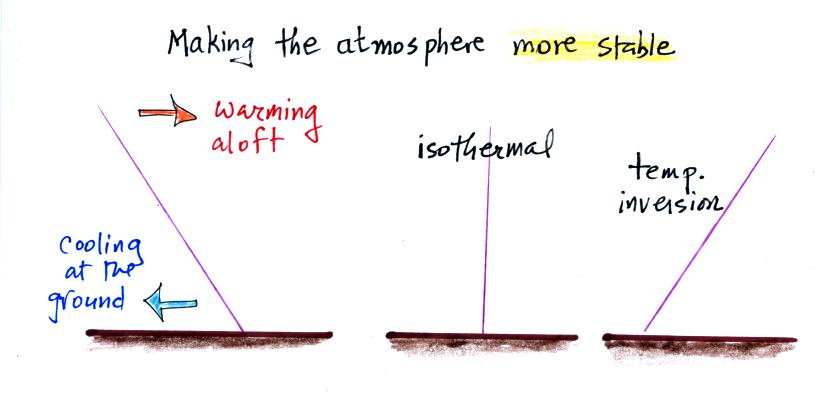

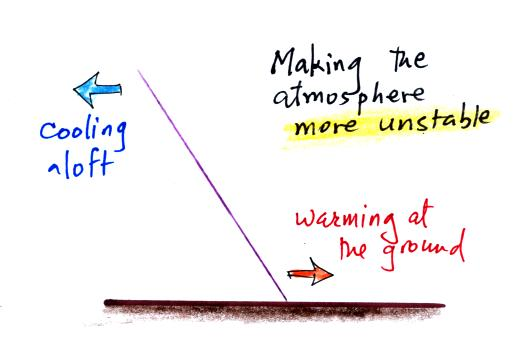

credit to: http://www.atmo.arizona.edu/students/courselinks/fall15/atmo170a1s3/1S1P_stuff/stability/lect_stability.html

We now add **dry convection** to the radiative model. The result is a **radiative–convective model**: radiation determines heating and cooling rates, while convection adjusts the temperature profile when it becomes unstable.

Build a dry radiative–convective model, then visualize its adjustment with an animation.

Initialize the coupled radiation and dry‑convection model.

In [ ]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Build the radiation model -- just like we already did
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=mystate,
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )
#  Now create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=9.8, # put in the dry adiabatic lapse rate
                                               timestep=rad.timestep,  # same timestep!
                                              )
#  Here is where we build the model by coupling together the two components
rcm_dry = climlab.couple([rad, conv], name='Radiative-Convective Model')

The code below is complicated but it is mostly for generating an animation. Focus on the results, not the code here.

Set up helper functions for plotting tendencies and building the animation.

In [ ]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation
import matplotlib.colors as mcolors

def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topname='Total', topdown=False):
        tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
        tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

def initial_figure(model):
    fig = plt.figure(figsize=(14,6))
    lines = []

    skew = SkewT(fig, subplot=(1,2,1), rotation=30)
    #  plot the observations
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
              linestyle='-', linewidth=2, color='C0', label='RC model (all gases)')[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o',
                  markersize=8, color='C0', )[0])

    ax = fig.add_subplot(1,2,2, sharey=skew.ax)
    ax.set_ylim(1050, 10)
    ax.set_xlim(-8,8)
    ax.grid()
    ax.set_xlabel('Temperature tendency ($^\circ$C day$^{-1}$)', fontsize=14)

    color_cycle=[mcolors.TABLEAU_COLORS[key] for key in mcolors.TABLEAU_COLORS]
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines.append(ax.plot(tendencies_atm[name], model.lev, label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 1000, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(skew.ax.text(-100, 50, 'Day {}'.format(int(model.time['days_elapsed'])), fontsize=12))
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines[2+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[2+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

We are going to start from an **isothermal initial state**, and let the model drift toward equilibrium.

> An isothermal initial state means that the temperature is the same at all vertical levels (and typically equal to the surface temperature). In other words, the atmosphere begins with no vertical temperature gradient. This is not physically realistic, but it provides a simple, neutral starting point. As the model evolves, radiation and convection will adjust the temperature profile toward a physically consistent equilibrium.

Initialize the model, compute diagnostics, and plot the initial profile and tendencies.

In [ ]:
#  Start from isothermal state
rcm_dry.state.Tatm[:] = rcm_dry.state.Ts
#  Call the diagnostics once for initial plotting
rcm_dry.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm_dry)

> In a skew-T plot, isotherms are slanted by design. The blue line may tilt to the right, but it represents a constant temperature with height (here 15°C, chosen arbitrarily).

The plot on the right shows **temperature tendencies**: the rate of temperature change due to each process. Values to the right indicate warming; values to the left indicate cooling.

**Q (wb-q8):** The initial tendency from convection is zero everywhere. Why? Shortwave radiation tends to warm everywhere. Why? Longwave radiation tends to cool everywhere. The cooling is especially strong aloft. Why? The total tendency (black) shows warming at the surface and cooling in the atmosphere. What should happen next? What are the implications for convective instability?

Now let’s look at how the model actually adjusts to this initial state.

Run the animation to visualize the adjustment over time.

In [ ]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 150, fargs=(rcm_dry, lines),blit=True)
HTML(ani.to_jshtml())

**Q (wb-q9):** Pause the video near the last frame and look carefully. Compare this result to the pure radiative equilibrium profile. Does adding dry convection improve the simulated temperature profile? Looking at the temperature tendencies, what is the role of the convection process? (Hint: look at where it adds or removes heat.)

------------------------------------------------------------------------

------------------------------------------------------------------------

### 2.4 + Moist convection

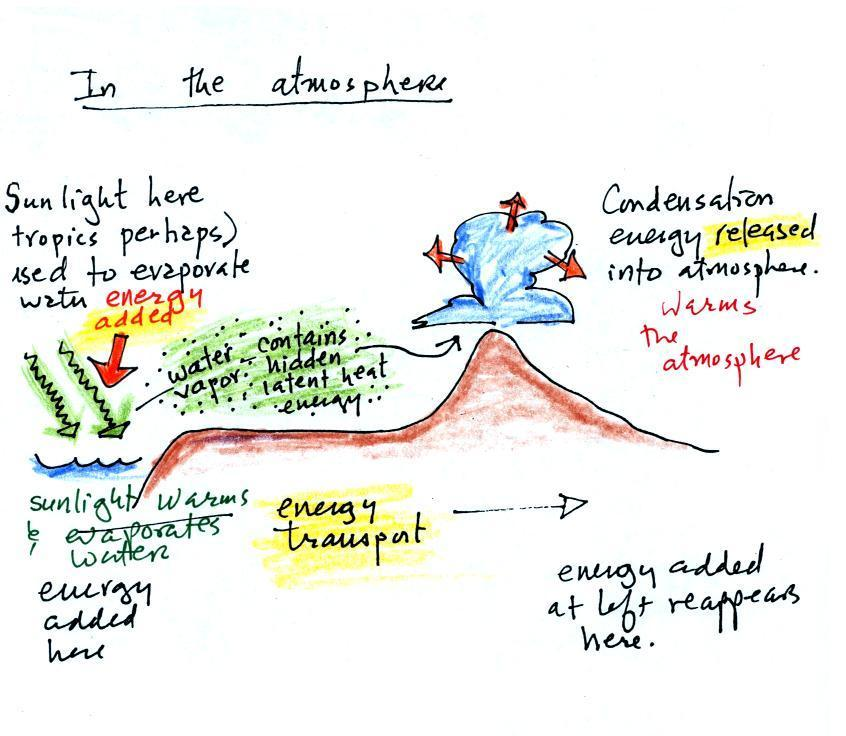

credit to: http://www.atmo.arizona.edu/students/courselinks/spring13/atmo170a1s1/online_course/week_4/lect11_temperature_conduction_convection_latent_heat.html

Configure moist convection and visualize how the profile adjusts.

The key parameter in `ConvectiveAdjustment` is `adj_lapse_rate`, which we now set to the moist adiabatic lapse rate.

1.  Choose a representative moist adiabatic lapse rate for the adjustment.

In [ ]:
# Set the `adj_lapse_rate` to a value for the moist adiabatic lapse rate
dry_adj_lapse_rate = 

\2. Create a moist‑convection model and couple it to radiation.

In [ ]:
#  Create a moist convection model
moist_conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=dry_adj_lapse_rate, # put in the moist adiabatic lapse rate
                                               timestep=rad.timestep,  # same timestep!
                                              )
#  Here is where we build the model by coupling together the two components
rcm = climlab.couple([rad, moist_conv], name='Radiative-Convective Model (moist)')

\3. Initialize the model and plot the initial state.

In [ ]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

\4. Run the moist‑convection animation.

In [ ]:
#  create a new animation in the notebook
ani2 = animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines),blit=True, repeat=False)
HTML(ani2.to_jshtml())

**Q (wb-q10):** Pause the video near the last frame and look carefully. Does adding moist convection improve the simulated temperature profile? Is it closer to dry adiabats (red dashed lines) or moist adiabats (blue dashed lines)? How does the temperature tendency due to moist convection compare to the dry convection case?

------------------------------------------------------------------------

------------------------------------------------------------------------

## Part 3: Climate Feedbacks in a 1D Model

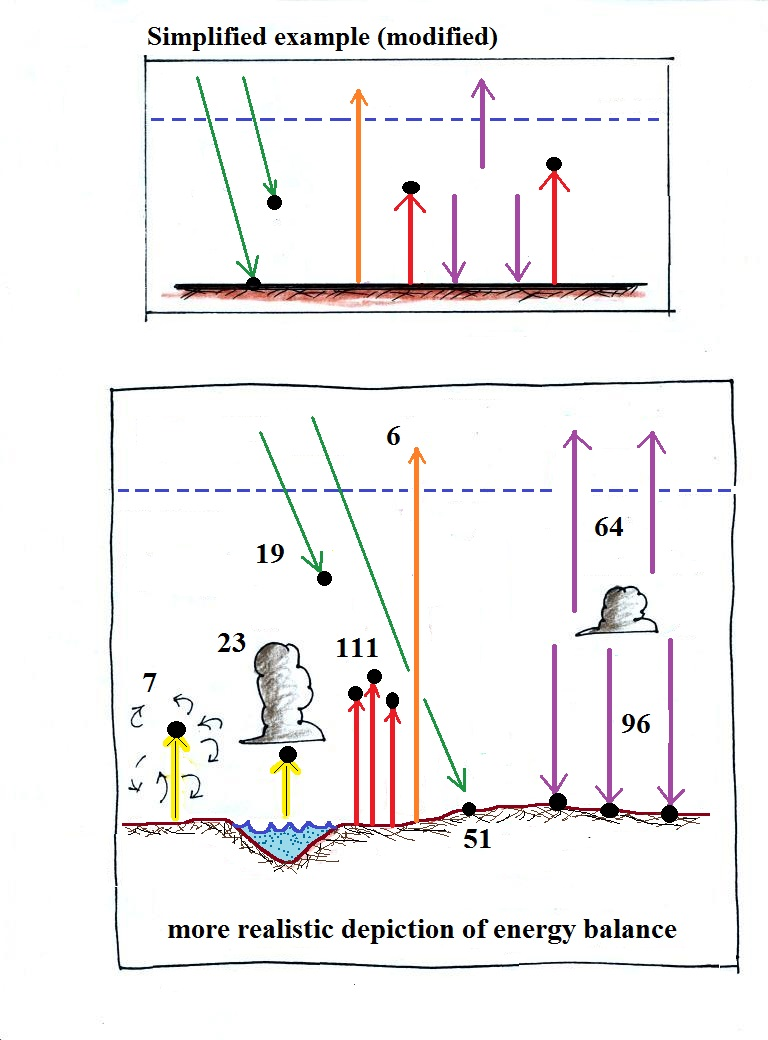

Credit to: http://www.atmo.arizona.edu/students/courselinks/spring08/atmo336s1/courses/fall19/atmo170a1s1/lecture_notes/oct15.html

### 3.1 Equilibrium Climate Sensitivity — without feedbacks

To establish a baseline, we first compute ECS due to CO$_2$ alone, balanced only by the **Planck response**, which is implicit in the radiation model.

In this case, we hold humidity and lapse rate fixed. The only mechanism restoring balance is the increase in outgoing radiation as temperature rises. This provides a reference sensitivity before adding additional feedback processes.

Integrate the control model, double CO$_2$, and compute ECS without feedbacks.

In [ ]:
# Integrate out to equilibrium
rcm.integrate_years(5)

Let’s check that we are indeed in energy balance by comparing **absorbed solar radiation (ASR)** and **outgoing longwave radiation (OLR)** at the top of the atmosphere.

-   **ASR** is the incoming solar energy absorbed by the Earth system (incoming shortwave minus reflected shortwave).
-   **OLR** is the infrared energy emitted to space (sometimes informally called “Earthlight”).

If the model has reached equilibrium, these should be nearly equal:

The difference $( \text{ASR} - \text{OLR} )$ is the net radiative imbalance. Positive means the system is gaining energy (warming); negative means it is losing energy (cooling).

In [ ]:
rcm.ASR - rcm.OLR

1.  Clone the model and double CO$_2$.

In [ ]:
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.name = 'Radiative-Convective Model (2xCO2 initial)'
#  Now double CO2 concentration
rcm_2xCO2.subprocess['Radiation (net)'].absorber_vmr['CO2'] *= 2
#  and check
co2 = rcm_2xCO2.subprocess['Radiation (net)'].absorber_vmr['CO2']
print("This model atmosphere has a CO2 concentration of " + str(1e6*co2) +" ppm")

\2. Allow the stratosphere to adjust while holding the troposphere and surface fixed.

In [ ]:
rcm_2xCO2_strat = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_strat.name = 'Radiative-Convective Model (2xCO2 stratosphere-adjusted)'
for n in range(1000):
    rcm_2xCO2_strat.step_forward()
    # hold tropospheric and surface temperatures fixed
    rcm_2xCO2_strat.Tatm[13:] = rcm.Tatm[13:]
    rcm_2xCO2_strat.Ts[:] = rcm.Ts[:]
# Now calculate the stratosphere-adjusted radiative forcing
DeltaR = (rcm_2xCO2_strat.ASR - rcm_2xCO2_strat.OLR) - (rcm.ASR - rcm.OLR)
print('The stratosphere-adjusted radiative forcing is {:.3} W/m2.'.format(float(DeltaR)))

\3. Integrate the doubled‑CO$_2$ model to equilibrium.

In [ ]:
rcm_2xCO2_eq = climlab.process_like(rcm_2xCO2_strat)
rcm_2xCO2_eq.name = 'Radiative-Convective Model (2xCO2 equilibrium)'
rcm_2xCO2_eq.integrate_years(5)

\4. Plot the control, stratosphere‑adjusted, and equilibrated profiles.

In [ ]:
skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_strat)
add_profile(skew, rcm_2xCO2_eq)

Compute ECS without feedbacks.

In [ ]:
ECS_nofeedback = rcm_2xCO2_eq.Ts - rcm.Ts
print("Without feedbacks, ECS is {:2.4f} K".format(ECS_nofeedback[0]))

If this confirms the claim made in class that a CO$_2$ doubling, **on its own**, would only warm the Earth by about 1.3 K, what’s missing from this picture?

------------------------------------------------------------------------

------------------------------------------------------------------------

### 3.2 Water vapor feedback

**Q (wb-q12):** The Clausius–Clapeyron relation links $e_{s(T)}$ to $T$. What functional form does it take (approximately)? Given this, do you expect the water vapor feedback to be stabilizing or destabilizing?

We first calculate the relative humidity profile in the control run so we can then hold RH fixed in our “climate change” (2xCO$_2$) simulations.

Compute relative humidity from the control run, then rerun 2xCO$_2$ with fixed relative humidity, and plot both specific humidity and RH profiles.

In [ ]:
#  actual specific humidity
q = rcm.subprocess['Radiation (net)'].specific_humidity
#  saturation specific humidity (a function of temperature and pressure)
qsat = climlab.utils.thermo.qsat(rcm.Tatm, rcm.lev)
#  Relative humidity
rh = q/qsat

#  Plot relative humidity in percent
fig,ax = plt.subplots()
ax.plot(q*1000, rcm.lev)
ax.invert_yaxis()
ax.grid()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)', color='C0')
ax.tick_params('x', colors='C0')
ax2 = ax.twiny()
ax2.plot(rh*100., rcm.lev, color='C1')
ax2.set_xlabel('Relative humidity (%)', color='C1')
ax2.tick_params('x', colors='C1')

In the following, we will **fix the RH profile** and allow specific humidity to adjust as saturation specific humidity $q_s(T)$ increases in a warming climate.

1.  Clone our radiative–convective model so we can prescribe this relative humidity profile.

In [ ]:
rcm_2xCO2_h2o = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_h2o.name = 'Radiative-Convective Model (2xCO2 equilibrium with H2O feedback)'

\2. Integrate forward while holding RH fixed.

In [ ]:
for n in range(2000):
    # At every timestep
    # we calculate the new saturation specific humidity for the new temperature
    #  and change the water vapor in the radiation model
    #  so that relative humidity is always the same
    qsat = climlab.utils.thermo.qsat(rcm_2xCO2_h2o.Tatm, rcm_2xCO2_h2o.lev)
    rcm_2xCO2_h2o.subprocess['Radiation (net)'].specific_humidity[:] = rh * qsat
    rcm_2xCO2_h2o.step_forward()

\3. Check that the model has reached energy balance.

In [ ]:
# Check for energy balance
rcm_2xCO2_h2o.ASR - rcm_2xCO2_h2o.OLR

\4. Plot the control, fixed‑humidity, and interactive‑humidity profiles.

In [ ]:
skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_eq)
add_profile(skew, rcm_2xCO2_h2o)

**Q (wb-q13):** What do you notice? What was the effect of including interactive moisture? (compare the orange and green curves)

Run the cell below to compute ECS in this model, and deduce the additional warming associated with the water vapor feedback.

In [ ]:
ECS_h20 = rcm_2xCO2_h2o.Ts - rcm.Ts
print("With interactive moisture, ECS is {:2.2f} K".format(ECS_h20[0]))
print("This is an added {:2.2f} K compared to the no-feedback case".format(ECS_h20[0]-ECS_nofeedback[0]))

------------------------------------------------------------------------

------------------------------------------------------------------------

### 3.3 Lapse-rate feedback

**Q (wb-q14):** Based on this discussion, do you expect this effect to stabilize or destabilize surface temperature? Explain your reasoning.

We will implement this **lapse-rate feedback** using:

where $\Gamma_{ref}$ is the reference critical lapse rate (e.g., 6.5 K/km) and $\Delta T_s$ is the current surface warming relative to the control (K).

Implement a lapse‑rate feedback rule and recompute ECS.

In [ ]:
# Now clone the model with doubled CO2
rcm_2xCO2_h2o_lapse = climlab.process_like(rcm_2xCO2_strat)
rcm_2xCO2_h2o_lapse.name = 'Radiative-Convective Model (2xCO2 equilibrium with H2O and lapse rate feedback)'
# And timestep forward, adjusting the specific humidity and lapse rate at every timestep
Gamma_ref = 6.5  #  the reference critical lapse rate in K / km
for n in range(2000):
    # Calculate current saturation specific humidity
    qsat = climlab.utils.thermo.qsat(rcm_2xCO2_h2o_lapse.Tatm, rcm_2xCO2_h2o_lapse.lev)
    #  Set the current specific humidity so that RH stays constant
    rcm_2xCO2_h2o_lapse.subprocess['Radiation (net)'].specific_humidity[:] = rh * qsat
    #  Calculate the current surface warming
    DeltaTs = rcm_2xCO2_h2o_lapse.Ts - rcm.Ts
    #  Implement the lapse-rate feedback
    rcm_2xCO2_h2o_lapse.subprocess['Convection'].adj_lapse_rate = Gamma_ref - 0.3*DeltaTs  # THIS IS WHERE THE MAGIC HAPPENS
    #  And finally take a single step forward
    rcm_2xCO2_h2o_lapse.step_forward()

Plot the profiles with lapse‑rate feedback included.

In [ ]:
%matplotlib inline
# %matplotlib notebook
skew = make_skewT()
add_profile(skew, rcm_2xCO2_eq)
add_profile(skew, rcm_2xCO2_h2o)
add_profile(skew, rcm_2xCO2_h2o_lapse)

**Q (wb-q15):** Calculate ECS in this model. Does this result confirm the intuition built in Question 3.3.1?

Compute ECS with combined water‑vapor and lapse‑rate feedbacks.

In [ ]:
ECS_h2o_lapse = rcm_2xCO2_h2o_lapse.Ts - rcm.Ts
print('The Equilibrium Climate Sensitivity with combined lapse rate and water vapor feedback is {:.3} K.'.format(float(ECS_h2o_lapse)))